# Using TensorFlow without GPU for `lagaris01`

## Introduction

The purpose of this notebook is to experiment with TensorFlow (without using the GPU) for the solution of the `lagaris01` ODE.

## The `lagaris01` problem

This ODE was used as the first example problem in (Lagaris et al., 1998). It has been used in several other papers in the neural network/differential equation literature. The differential equation is provided in the form (equation (27) in Lagaris (1998)):

\begin{equation}
    \frac {d\psi} {dx} + \left (x+\frac {1+3x^2} {1+x+x^3} \right ) \psi =
    x^3 + 2x + x^2 \frac {1+3x^2} {1+x+x^3}
\end{equation}

or:

\begin{equation}
    G\left(x,\psi,\frac {d\psi}{dx}\right) = \frac {d\psi} {dx} + \left (x+\frac {1+3x^2} {1+x+x^3} \right ) \psi - x^3 - 2x - x^2 \frac {1+3x^2} {1+x+x^3} = 0
\end{equation}

The initial condition is:

\begin{equation}
    \psi(0)=1
\end{equation}

The analytical solution is:

\begin{equation}
    \psi_a(x) = x^2 + \frac {e^{-x^2/2}} {1 + x +  x^3}
\end{equation}

The first derivative is:

\begin{equation}
    \frac {d\psi_a} {dx} = 2x - \frac {e^{-x^2/2} (1+x+4x^2+x^4)} {(1+x+x^3)^2}
\end{equation}

The analytical solution and derivative in the domain $[0,1]$ are plotted below.

In [12]:
# Import standard Python modules.
import datetime
from math import exp, sqrt
import matplotlib.pyplot as plt
import numpy as np

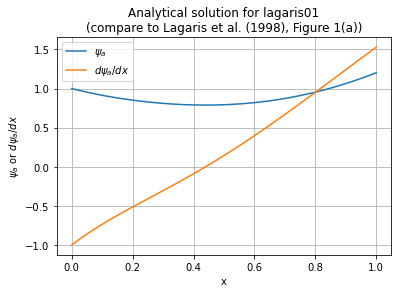

In [13]:
# Load the equation.
eq_name = "lagaris01"
import nnde.differentialequation.examples.lagaris_01 as lagaris01

# Compute the analytical solution and derivative.
n_a = 101
x_a = np.linspace(0, 1, n_a)
Ya = [lagaris01.Ya(x) for x in x_a]
dYa_dx = [lagaris01.dYa_dx(x) for x in x_a]

# Plot the analytical solution and derivative.
plt.plot(x_a, Ya, label="$\psi_a$")
plt.plot(x_a, dYa_dx, label="$d\psi_a/dx$")
plt.xlabel("x")
plt.ylabel("$\psi_a$ or $d\psi_a/dx$")
plt.grid()
plt.legend()
plt.title("Analytical solution for %s\n(compare to Lagaris et al. (1998), Figure 1(a))" %
         (eq_name));

## Solving `lagaris01` using TensorFlow, without the GPU

In [14]:
import tensorflow as tf

# Disable the GPU.
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

### Shared hyperparameters

In [15]:
# Network hidden node counts.
sizes = list(range(10, 11, 10))

# Training data range
x_min = 0
x_max = 1

# Number of training points.
n_t = 101

# Compute the training data.
x_t = np.linspace(x_min, x_max, n_t)

# Learning rate
learning_rate = 0.01

# Number of training epochs
n_epochs = 1000

# Starting ranges for weights and biases.
b_min = -0.1
b_max = 0.1
v_min = -0.1
v_max = 0.1
w_min = -0.1
w_max = 0.1

In [16]:
# Initialize the lists of models, losses, run times, and epoch times.
tf_nets = []
tf_losses = []
tf_run_times = []
tf_epoch_times = []

# Convert the training data to a TensorFlow Variable.
x_tv = tf.Variable(x_t.reshape((n_t, 1)), dtype=tf.float32)

# Use double-precision math.
# tf.keras.backend.set_floatx('float64')

# Build and run the network for each layer size.
for H in sizes:
    print("Building network with %s hidden nodes." % (H))

    # Create the network.
    tf.random.set_seed(0)
    hidden_layer = tf.keras.layers.Dense(
        units=H, use_bias=True,
        activation=tf.keras.activations.sigmoid,
        kernel_initializer=tf.keras.initializers.RandomUniform(minval=w_min, maxval=w_max),
        bias_initializer=tf.keras.initializers.RandomUniform(minval=b_min, maxval=b_max)
    )
    output_layer = tf.keras.layers.Dense(
        units=1, use_bias=False,
        activation=tf.keras.activations.linear,
        kernel_initializer=tf.keras.initializers.RandomUniform(minval=v_min, maxval=v_max)
    )
    model = tf.keras.Sequential([hidden_layer, output_layer])

    # Train the network for the specified number of epochs.
    x = x_tv
    losses = []
    print("Starting training for %s epochs." % (n_epochs))
    t_start = datetime.datetime.now()
    print(t_start)
    for i in range(n_epochs):

        # Compute the forward pass for each training point.
        with tf.GradientTape(persistent=True) as tape:
            N = model(x)
            N = tf.reshape(N, (n_t, 1))
            y = 1 + x*N
            dN_dx = tape.gradient(N, x)
            G = x*dN_dx + N + (x + (1 + 3*x**2)/(1 + x + x**3))*y - x**3 - 2*x - x**2*(1 + 3*x**2)/(1 + x + x**3)
            L = tf.sqrt(tf.reduce_sum(G**2)/x.shape[0])
            losses.append(L.numpy())

        # Compute the gradients.
        grads = tape.gradient(L, model.trainable_variables)

        # Update the parameters for this pass.
        for (v, d) in zip(model.trainable_variables, grads):
            v.assign_sub(learning_rate*d)

    t_stop = datetime.datetime.now()
    print(t_stop)
    t_elapsed = t_stop - t_start
    t_epoch = t_elapsed/n_epochs
    print("Elapsed time (s): %s, time per epoch: %s" % (t_elapsed, t_epoch))

    # Save the model, loss history, and elapsed time.
    tf_nets.append(model)
    tf_losses.append(losses)
    tf_run_times.append(t_elapsed)
    tf_epoch_times.append(t_epoch)

Building network with 10 hidden nodes.
Starting training for 1000 epochs.
2021-07-03 09:21:34.052997
2021-07-03 09:21:38.430142
Elapsed time (s): 0:00:04.377145, time per epoch: 0:00:00.004377


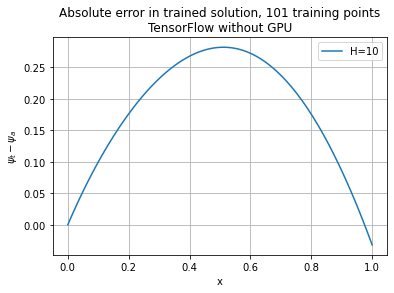

In [17]:
# Plot the error in the trained solution for each network.
for (model, H) in zip(tf_nets, sizes):
    N = model(x_tv).numpy()[:, 0]
    Yt = 1 + x_t*N
    Ya = [lagaris01.Ya(x) for x in x_t]
    Yerr = Yt - Ya
    plt.plot(x_t, Yerr, label="H=%s" % H)

plt.title("Absolute error in trained solution, %s training points\nTensorFlow without GPU" % (n_t))
plt.xlabel("x")
plt.ylabel("$\psi_t - \psi_a$")
plt.grid()
plt.legend()
plt.show()

In [18]:
# Plot the error in the trained derivative for each network.

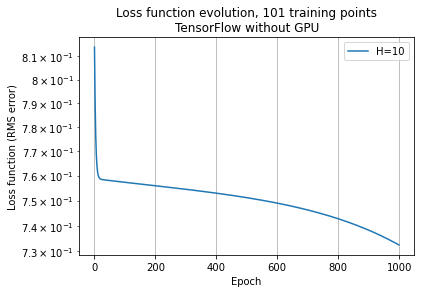

In [19]:
# Plot the loss function history for each network.
for (net, H, losses) in zip(tf_nets, sizes, tf_losses):
    plt.semilogy(losses, label="H=%s" % H)

plt.title("Loss function evolution, %s training points\nTensorFlow without GPU" % (n_t))
plt.xlabel("Epoch")
plt.ylabel("Loss function (RMS error)")
plt.grid()
plt.legend()
plt.show()

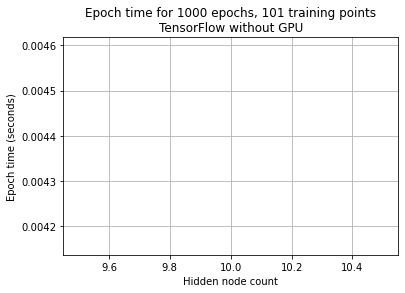

In [20]:
# Plot the epoch times.
epoch_times = [t.total_seconds() for t in tf_epoch_times]
plt.plot(sizes, epoch_times)

plt.title("Epoch time for %s epochs, %s training points\nTensorFlow without GPU" % (n_epochs, n_t))
plt.xlabel("Hidden node count")
plt.ylabel("Epoch time (seconds)")
plt.grid()
plt.show()

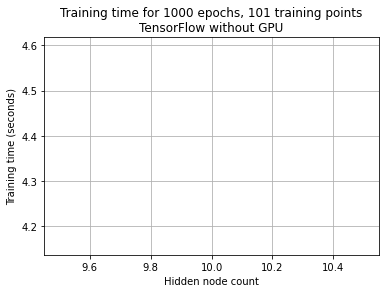

In [21]:
# Plot the total times.
training_times = [t.total_seconds() for t in tf_run_times]
plt.plot(sizes, training_times)

plt.title("Training time for %s epochs, %s training points\nTensorFlow without GPU" % (n_epochs, n_t))
plt.xlabel("Hidden node count")
plt.ylabel("Training time (seconds)")
plt.grid()
plt.show()